In [2]:
#!git clone https://github.com/brewing-datacup/reto-colombia-2020

In [3]:
#!pip install patool

In [4]:
#!pip install pyunpack
#from pyunpack import Archive
#Archive("/content/reto-colombia-2020/data/colombia-data.7z").extractall("/content/drive/My Drive/Reto/")

In [5]:
import pandas as pd
import numpy as np
import datetime
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sb
import math
%matplotlib inline

In [6]:
clientes_df = pd.read_csv("/content/drive/My Drive/Reto/Input1_clientes_estructura.csv", sep =';')
ventas_df = pd.read_csv("/content/drive/My Drive/Reto/Input2_clientes_venta.csv", sep =';')
base_pred= pd.read_csv("/content/drive/My Drive/Reto/Input3_clientes_test.csv", sep=";")

In [7]:
ventas_df.replace({'Marca2': r'^Marca','Cupo2': r'^Cupo','CapacidadEnvase2': r'^CapacidadEnvase'}
                  , {'Marca2': 'M', 'Cupo2':'C','CapacidadEnvase2':'CE'}, regex=True,inplace=True)

In [8]:
ventas_df['Fecha'] = pd.to_datetime(ventas_df['Año'].astype(str)+ ventas_df['Mes'].apply(lambda x: '0'+str(x) if x<=9 else str(x)) +'01')
ventas_df['Marca'] = ventas_df['Marca2']+'-'+ventas_df['Cupo2']+'-'+ventas_df['CapacidadEnvase2']
ventas_df=ventas_df[ventas_df['Volumen']>0.01]
ventas_df.drop(columns=['Año','Mes','Marca2','Cupo2','CapacidadEnvase2'], inplace=True)
prueba = ventas_df

In [9]:
marcas_minimas =pd.DataFrame(ventas_df.groupby(['Marca'])['Marca'].count().sort_values())
marcas_minimas.columns=['Cantidad']
marcas_minimas.reset_index(inplace=True)
marcas= marcas_minimas[marcas_minimas['Cantidad']>=2000]['Marca'].to_list()
ventas_df=ventas_df[ventas_df['Marca'].isin(marcas)]
prueba = ventas_df

In [10]:
grouped_cliente = prueba.groupby(['Cliente','Fecha']).agg({'Volumen': ['sum'],'disc': ['sum'],'nr': ['sum'],'Marca':['nunique']}).reset_index()
grouped_cliente.columns = ['Cliente','Fecha','volumen_cliente','descuento_cliente','valor_cliente','distinct_marca_cliente']

In [11]:
grouped_cliente_marca = prueba.groupby(['Cliente','Fecha', 'Marca']).agg({'Volumen': ['sum'],'disc': ['sum'],'nr': ['sum']}).reset_index()
grouped_cliente_marca.columns = ['Cliente','Fecha','Marca','volumen_marca','descuento_marca','valor_marca']

In [12]:
grouped_cliente_marca.sort_values(['Cliente','Fecha','Marca'],inplace=True)
grouped_cliente_marca['diff_vol_marca']=grouped_cliente_marca.groupby(['Cliente','Marca'])['volumen_marca'].transform(pd.Series.diff).fillna(grouped_cliente_marca['volumen_marca'])
grouped_cliente_marca['ant_volumen_marca']=grouped_cliente_marca.groupby(['Cliente','Marca'])['volumen_marca'].shift(1)

In [13]:
prueba_2 = pd.merge(grouped_cliente, grouped_cliente_marca, left_on=['Cliente','Fecha'], right_on=['Cliente','Fecha'], how="left")

In [14]:
prueba_2['p_vol'] =prueba_2['volumen_marca']/prueba_2['volumen_cliente']
prueba_2['p_desc'] =prueba_2['descuento_marca']/prueba_2['descuento_cliente']
prueba_2['p_valor'] =prueba_2['valor_marca']/prueba_2['valor_cliente']
prueba_2['p_variacion'] = (prueba_2['diff_vol_marca']/prueba_2['ant_volumen_marca']).apply(lambda x: 0 if x==math.inf else x)
prueba_2.fillna(0,inplace=True)

In [15]:
prueba_2.drop(columns=['volumen_marca','descuento_marca','valor_marca','diff_vol_marca','ant_volumen_marca'], inplace=True)

In [16]:
prueba3= pd.pivot_table(prueba_2, values=['p_vol','p_desc','p_valor','p_variacion'],
                         index=['Cliente','Fecha','volumen_cliente','descuento_cliente','valor_cliente','distinct_marca_cliente'],
                         columns=['Marca'], aggfunc=np.mean).reset_index()

In [17]:
prueba3.columns = ['_'.join(col) for col in prueba3.columns]
prueba3.rename(columns={'Cliente_': 'Cliente', 
                        'Fecha_': 'Fecha',
                        'volumen_cliente_':'volumen_cliente',
                        'descuento_cliente_':'descuento_cliente',
                        'valor_cliente_':'valor_cliente',
                        'distinct_marca_cliente_':'distinct_marca_cliente'}, inplace=True)

In [18]:
prueba3.fillna(0, inplace=True)

In [19]:
ult_3_meses_train= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-07-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-05-01'))]
ult_6_meses_train= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-07-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-01-01'))]
ult_12_meses_train= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-07-01'))&(prueba3['Fecha']>=pd.to_datetime('2019-07-01'))]

In [20]:
ult_3_meses_test= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-08-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-06-01'))]
ult_6_meses_test= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-08-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-02-01'))]
ult_12_meses_test= prueba3[(prueba3['Fecha']<=pd.to_datetime('2020-08-01'))&(prueba3['Fecha']>=pd.to_datetime('2019-08-01'))]

In [21]:
columnas = prueba3.columns.to_list()
columnas.remove('Cliente')
columnas.remove('Fecha') 

estaditicas = ['mean','median']

agg_group ={}

for i in columnas :
    key=i
    agg_group[key] = estaditicas
agg_group['Fecha'] =['nunique']

In [22]:
#ult_3_meses_test["p_variacion_M_38-C_2-CE_10"][ult_3_meses_test["Cliente"]==862]
#prueba3["p_variacion_M_38-C_2-CE_10"][prueba3["Cliente"]==862]
#prueba_2[(prueba_2["Cliente"]==862) & (prueba_2["Marca"]=="M_38-C_2-CE_10")]

In [23]:
# g=ult_3_meses_test_agg[["p_variacion_M_38-C_2-CE_10_3_mean","Cliente"]].set_index("Cliente")
# g[g.isin([np.inf])]
#k=ult_3_meses_test_agg[["p_variacion_M_38-C_2-CE_10","Cliente"]].set_index("Cliente")
#k.columns.to_series()[np.isinf(k).any()]
#[k.isin([np.inf]).any(1)]
#ult_3_meses_test_agg = ult_3_meses_train.groupby(['Cliente']).agg(agg_group).reset_index()
#ult_3_meses_test_agg

In [24]:
ult_3_meses_train_agg = ult_3_meses_train.groupby(['Cliente']).agg(agg_group).reset_index()
ult_3_meses_train_agg.columns = ['_3_'.join(col) for col in ult_3_meses_train_agg.columns]
ult_3_meses_train_agg.rename(columns={'Cliente_3_': 'Cliente'}, inplace=True)
ult_6_meses_train_agg = ult_6_meses_train.groupby(['Cliente']).agg(agg_group).reset_index()
ult_6_meses_train_agg.columns = ['_6_'.join(col) for col in ult_6_meses_train_agg.columns]
ult_6_meses_train_agg.rename(columns={'Cliente_6_': 'Cliente'}, inplace=True)
ult_12_meses_train_agg = ult_12_meses_train.groupby(['Cliente']).agg(agg_group).reset_index()
ult_12_meses_train_agg.columns = ['_12_'.join(col) for col in ult_12_meses_train_agg.columns]
ult_12_meses_train_agg.rename(columns={'Cliente_12_': 'Cliente'}, inplace=True)

In [25]:
ult_3_meses_test_agg = ult_3_meses_test.groupby(['Cliente']).agg(agg_group).reset_index()
ult_3_meses_test_agg.columns = ['_3_'.join(col) for col in ult_3_meses_test_agg.columns]
ult_3_meses_test_agg.rename(columns={'Cliente_3_': 'Cliente'}, inplace=True)
ult_6_meses_test_agg = ult_6_meses_test.groupby(['Cliente']).agg(agg_group).reset_index()
ult_6_meses_test_agg.columns = ['_6_'.join(col) for col in ult_6_meses_test_agg.columns]
ult_6_meses_test_agg.rename(columns={'Cliente_6_': 'Cliente'}, inplace=True)
ult_12_meses_test_agg = ult_12_meses_test.groupby(['Cliente']).agg(agg_group).reset_index()
ult_12_meses_test_agg.columns = ['_12_'.join(col) for col in ult_12_meses_test_agg.columns]
ult_12_meses_test_agg.rename(columns={'Cliente_12_': 'Cliente'}, inplace=True)

In [26]:
clientes_df_dummies = pd.get_dummies(clientes_df)

In [27]:
base_train = pd.merge(clientes_df_dummies, ult_12_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_train = pd.merge(base_train, ult_6_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_train = pd.merge(base_train, ult_3_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_test = pd.merge(clientes_df_dummies, ult_12_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_test = pd.merge(base_test, ult_6_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_test = pd.merge(base_test, ult_3_meses_train_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_test.fillna(0, inplace=True)
base_train.fillna(0, inplace=True)

In [28]:
train_filtro=base_train['Cliente'].to_list()
test_filtro=base_test['Cliente'].to_list()

In [29]:
y_train = prueba_2[prueba_2['Fecha']==pd.to_datetime('2020-08-01')]
y_train = y_train[['Cliente','Marca']]
y_train = pd.get_dummies(y_train)

columns_t = y_train.columns.to_list()
columns_t.remove('Cliente') 

estadisticas_t = ['sum']

agg_group_train ={}

for i in columns_t :
    key=i
    agg_group_train[key] = estadisticas_t
    
y_train = y_train.groupby(['Cliente']).agg(agg_group_train).reset_index()
y_train.columns = ['_'.join(col) for col in y_train.columns]
y_train.rename(columns={'Cliente_': 'Cliente'}, inplace=True)
y_train = y_train[y_train['Cliente'].isin(train_filtro)]

In [30]:
y_test = prueba_2[prueba_2['Fecha']==pd.to_datetime('2020-09-01')]
y_test = y_test[['Cliente','Marca']]
y_test = pd.get_dummies(y_test)

columns_te = y_test.columns.to_list()
columns_te.remove('Cliente') 

estadisticas_te = ['sum']

agg_group_test ={}

for i in columns_te :
    key=i
    agg_group_test[key] = estadisticas_te
    
y_test = y_test.groupby(['Cliente']).agg(agg_group_test).reset_index()
y_test.columns = ['_'.join(col) for col in y_test.columns]
y_test.rename(columns={'Cliente_': 'Cliente'}, inplace=True)
y_test = y_test[y_test['Cliente'].isin(test_filtro)]

In [31]:
train_filtro2=y_train['Cliente'].to_list()
test_filtro2=y_test['Cliente'].to_list()

In [32]:
base_train = base_train[base_train['Cliente'].isin(train_filtro2)]
base_test = base_test[base_test['Cliente'].isin(test_filtro2)]

In [33]:
y_train.set_index('Cliente' , inplace = True)
y_train.rename(columns={'Marca_M_20-C_3-CE_9_sum': 'M_20-C_3-CE_9', 
                        'Marca_M_16-C_2-CE_10_sum':'M_16-C_2-CE_10',
                        'Marca_M_9-C_3-CE_12_sum':'M_9-C_3-CE_12',
                        'Marca_M_38-C_2-CE_10_sum':'M_38-C_2-CE_10',
                        'Marca_M_39-C_2-CE_10_sum':'M_39-C_2-CE_10'
                        }, inplace=True)

In [56]:
base_test.set_index('Cliente' , inplace = True)

In [35]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import ParameterGrid
# import multiprocessing
# from sklearn.model_selection import RepeatedKFold

# columns =["M_20-C_3-CE_9","M_16-C_2-CE_10","M_9-C_3-CE_12","M_38-C_2-CE_10","M_39-C_2-CE_10"]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(base_train)
# w=50
# for i in columns :
#   # create the classifier
#   param_grid = {'n_estimators': [200],
#               'max_features': [10,20,50],
#               'max_depth'   : [ 3,  20],
#               'criterion'   : ['entropy']
#              }

# # Búsqueda por grid search con validación cruzada
# # ==============================================================================
#   model = GridSearchCV(
#         estimator  = RandomForestClassifier(class_weight={0: w, 1: 1},random_state = 9),
#         param_grid = param_grid,
#         scoring    = 'roc_auc',
#         n_jobs     = multiprocessing.cpu_count() - 1,
#         refit      = True,
#         verbose    = 0,
#         return_train_score = True)
  
#   y_base=y_train[i]
#   X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_scaled, y_base, test_size=0.3, random_state=8)
#   # Train the model using the training sets
#   model.fit(X_train, Y_train)
#   #y_pred = model.predict(X_test)
  
#   fpr, tpr, thresholds = metrics.roc_curve(Y_validation, model.predict_proba(X_validation)[:,1])
#   auc = metrics.roc_auc_score(Y_validation, model.predict_proba(X_validation)[:,1])
#   print("AUC: " + str(i)+" "+ str(auc))
#   print(model.best_params_)
  
#   with open("/content/drive/My Drive/Reto/smodel_3{}.pickle".format(i), "wb") as f:
#     pickle.dump(model, f) 


In [36]:
#columns =["M_20-C_3-CE_9","M_16-C_2-CE_10","M_9-C_3-CE_12","M_38-C_2-CE_10","M_39-C_2-CE_10"]

In [62]:
# # LOAD MODEL
# y_test.set_index('Cliente' , inplace = True)
# base_test.set_index('Cliente' , inplace = True)
y_test.rename(columns={'Marca_M_20-C_3-CE_9_sum': 'M_20-C_3-CE_9', 
                        'Marca_M_16-C_2-CE_10_sum':'M_16-C_2-CE_10',
                        'Marca_M_9-C_3-CE_12_sum':'M_9-C_3-CE_12',
                        'Marca_M_38-C_2-CE_10_sum':'M_38-C_2-CE_10',
                        'Marca_M_39-C_2-CE_10_sum':'M_39-C_2-CE_10'
                        }, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(base_test)


for i in columns: 
   with open("/content/drive/My Drive/Reto/smodel_3{}.pickle".format(i), "rb") as f:
     model = pickle.load(f)
     
     predicted= model.predict(X_scaled)
     fpr, tpr, thresholds = metrics.roc_curve(y_test[i], model.predict_proba(X_scaled)[:,1])
     auc = roc_auc_score(y_test[i], model.predict_proba(X_scaled)[:,1])
     CM = confusion_matrix(y_test[i], predicted)
     print(CM)
     #print("AUC: " + str(i)+" "+ str(auc))
    

[[11362   295]
 [ 1469   459]]
[[13396    21]
 [  154    14]]
[[10783     0]
 [ 2802     0]]
[[10811     0]
 [ 2671   103]]
[[11653   350]
 [ 1052   530]]


In [38]:
base_filtro=base_pred['Cliente'].to_list()
prueba4 = prueba3[prueba3['Cliente'].isin(base_filtro)]
clientes_df_dummies_2= clientes_df_dummies[clientes_df_dummies["Cliente"].isin(base_filtro)]

In [39]:
ult_3_meses_base= prueba4[(prueba4['Fecha']<=pd.to_datetime('2020-09-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-07-01'))]
ult_6_meses_base= prueba4[(prueba4['Fecha']<=pd.to_datetime('2020-09-01'))&(prueba3['Fecha']>=pd.to_datetime('2020-03-01'))]
ult_12_meses_base= prueba4[(prueba4['Fecha']<=pd.to_datetime('2020-09-01'))&(prueba3['Fecha']>=pd.to_datetime('2019-09-01'))]

ult_3_meses_base_agg = ult_3_meses_base.groupby(['Cliente']).agg(agg_group).reset_index()
ult_3_meses_base_agg.columns = ['_3_'.join(col) for col in ult_3_meses_base_agg.columns]
ult_3_meses_base_agg.rename(columns={'Cliente_3_': 'Cliente'}, inplace=True)
ult_6_meses_base_agg = ult_6_meses_base.groupby(['Cliente']).agg(agg_group).reset_index()
ult_6_meses_base_agg.columns = ['_6_'.join(col) for col in ult_6_meses_base_agg.columns]
ult_6_meses_base_agg.rename(columns={'Cliente_6_': 'Cliente'}, inplace=True)
ult_12_meses_base_agg = ult_12_meses_base.groupby(['Cliente']).agg(agg_group).reset_index()
ult_12_meses_base_agg.columns = ['_12_'.join(col) for col in ult_12_meses_base_agg.columns]
ult_12_meses_base_agg.rename(columns={'Cliente_12_': 'Cliente'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
base_fin = pd.merge(clientes_df_dummies_2,ult_12_meses_base_agg,left_on=['Cliente'], right_on=['Cliente'], how="left")
base_fin= pd.merge(base_fin, ult_6_meses_base_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_fin= pd.merge(base_fin, ult_3_meses_base_agg, left_on=['Cliente'], right_on=['Cliente'],how="left")
base_fin.set_index('Cliente' , inplace = True)

In [41]:
base_fin.fillna(0, inplace=True)
#base_fin1 =base_fin[base_fin.isin([np.inf]).any(1)]
#base_fin1
base_fin.columns.to_series()[np.isinf(base_fin).any()]

Series([], dtype: object)

In [59]:
from sklearn.metrics import plot_confusion_matrix
scaler = StandardScaler()
X_scaled1 = scaler.fit_transform(base_fin)
columns =["M_20-C_3-CE_9","M_16-C_2-CE_10","M_9-C_3-CE_12","M_38-C_2-CE_10","M_39-C_2-CE_10"]
for i in columns: 
   with open("/content/drive/My Drive/Reto/Mejor_pickle/smodel_3{}.pickle".format(i), "rb") as f:
     model = pickle.load(f)
     plot_confusion_matrix(model, base_test , y_test) 
     base_fin[i]=np.round(model.predict_proba(X_scaled1)[:,1],3)#df['column'].round(1)
base_predic=base_fin[columns]

ValueError: ignored

In [55]:
base_test

Cliente  Nevera  ...  p_vol_M_9-C_3-CE_3_3_median  Fecha_3_nunique
0            1       0  ...                          0.0              3.0
1            2       0  ...                          0.0              3.0
2            3       0  ...                          0.0              3.0
3            4       1  ...                          0.0              3.0
4            5       1  ...                          0.0              3.0
...        ...     ...  ...                          ...              ...
20409    20410       0  ...                          0.0              0.0
20410    20411       0  ...                          0.0              1.0
20413    20414       0  ...                          0.0              1.0
20433    20434       0  ...                          0.0              0.0
20579    20580       0  ...                          0.0              1.0

[13585 rows x 1231 columns]

In [44]:
#base_predic.reset_index(inplace=True)
base_predic.columns = ['Marca1',	'Marca2',	'Marca3',	'Marca_Inno1',	'Marca_Inno2']


In [ ]:
base_predic.to_csv("/content/drive/My Drive/Reto/output5_1_1.csv")

NameError: ignored

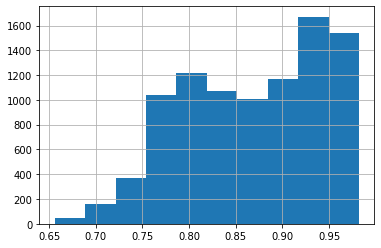

In [48]:
base_predic["Marca1"].hist()
py.plot